In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
import nana
from astropy import units as u

In [2]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [3]:
#create a delta f (1/tmax-min aka 1/total observation time
#delta_f = 1/lc.time[-1] - lc.time[0] #this is in days
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
print(total_observation_time)
delta_f = (1/total_observation_time) ###frequency resolution in data


1470.4622572100852


In [4]:
#this is cutting off at a low frequency, could be higher freq
sampling_rate_days= np.median(np.diff(lc.time.value))
f_max = 0.5*(1 / (sampling_rate_days))
print(f_max)

24.469500173919045


In [28]:
time_fake = lc.time.value
flux_fake =  1+ 0.01 * np.cos(2 * np.pi * time_fake) + 0.01* np.cos(4 * np.pi * time_fake) + 0.001 * np.random.normal(size=time_fake.shape) #fake flux data


lc_fake = lk.LightCurve(time=time_fake, flux=flux_fake) #light curve will automatically assume 
name_fake = "fake data"


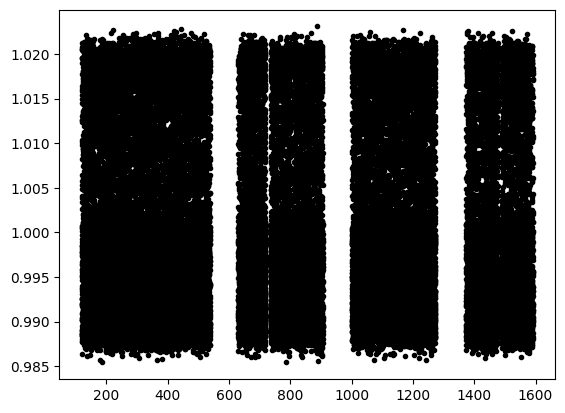

In [29]:
plt.plot(lc_fake.time.value,lc_fake.flux.value, 'k.')

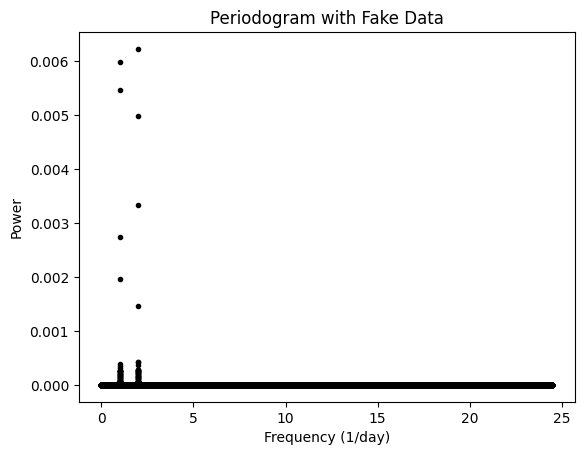

In [71]:
##using LightKurve Periodogram function, WITH DAYS!

#time is in days
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

pg_fake = lc_fake.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

fake_power = pg_fake.power.value

##IMPORTANT: when lightcurve uses to_periodogram(), it automatically converts to microhertz for some reason, so we must convert it back to days

fake_freq = pg_fake.frequency.to(1/u.day).value 
#fake_freq = pg_fake.frequency.value

plt.plot(fake_freq, fake_power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Periodogram with Fake Data")
plt.show() 

In [72]:
print(pg_fake.power)
print(lc_fake)

[8.75051525e-08 7.79483304e-08 5.62093794e-08 ... 2.04092493e-08
 2.50626661e-09 1.36250493e-08] 1 / uHz
       time               flux        flux_err
                                              
------------------ ------------------ --------
120.53882471062389 0.9984661662065752      nan
120.55925930149533 0.9973629611172362      nan
120.57969379242422 0.9946332785761637      nan
120.60012848328915 0.9950012129552915      nan
120.62056307421881 0.9918820621663633      nan
120.64099756508949 0.9919820144563306      nan
120.66143215601187 0.9904300149481913      nan
120.68186684694228 0.9894753005668075      nan
120.70230133787118 0.9891360611969203      nan
               ...                ...      ...
1590.8171708824957 0.9950945863472985      nan
1590.8376055308108 1.0012042959516805      nan
1590.8580399792118 1.0023343885337652      nan
 1590.878474527708 1.0077981970023866      nan
1590.8989091763142  1.010852486489912      nan
1590.9193436249916 1.0136091742490907      nan
 1

In [73]:
fake_ind = nana.get_started(2, fake_freq, fake_power)
print(fake_ind)

[8822 4410]


In [122]:
x,y,second_deriv = nana.refine_peaks(fake_freq,fake_power,fake_ind)
print(x,y,second_deriv)
print(fake_freq[fake_ind[0]])

[2.00000579 0.99999436] [0.00630729 0.006229  ] [-80382.88586149 -73261.55344479]
2.0000513345918676


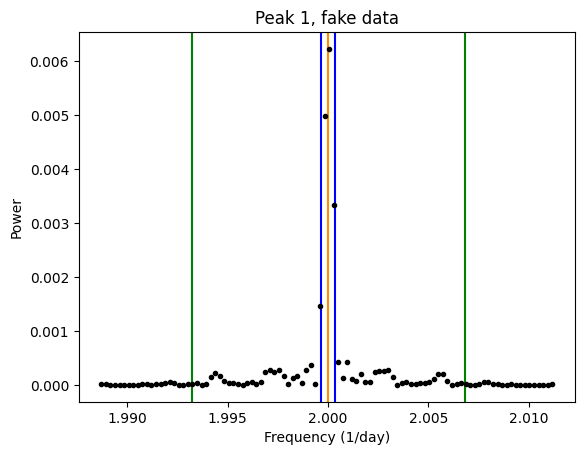

In [147]:
#Plot peak 1
plt.title("Peak 1, " + name_fake)
plt.axvline(x = x[0], color = 'darkorange')
#plt.axvline(x = fake_freq[fake_ind[0]], color = 'red')
plt.axvline(x = x[0]-delta_f/2, color = 'b')
plt.axvline(x = x[0]+delta_f/2, color = 'b')
plt.axvline(x = x[0]-10*delta_f, color = 'g')
plt.axvline(x = x[0]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(fake_freq[fake_ind[0]-50:fake_ind[0]+50], fake_power[fake_ind[0]-50:fake_ind[0]+50], 'k.')

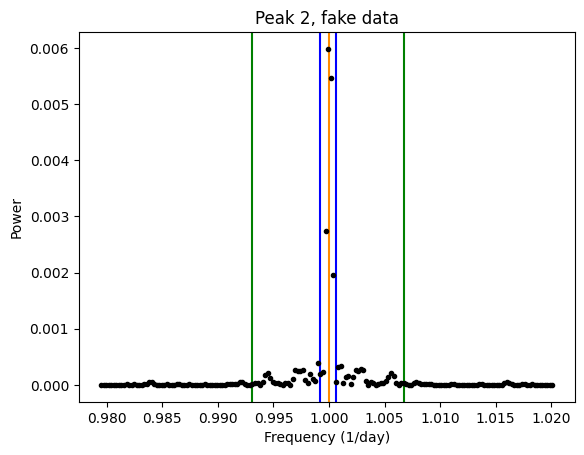

In [137]:
#Plot peak at 2
plt.title("Peak 2, " + name_fake)
#plt.axvline(x = fake_freq[fake_ind[1]], color = 'red')
plt.axvline(x = x[1], color = 'darkorange')
plt.axvline(x = fake_freq[fake_ind[1]]-delta_f, color = 'b')
plt.axvline(x = fake_freq[fake_ind[1]]+delta_f, color = 'b')
plt.axvline(x = fake_freq[fake_ind[1]]-10*delta_f, color = 'g')
plt.axvline(x = fake_freq[fake_ind[1]]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(fake_freq[fake_ind[1]-90:fake_ind[1]+90], fake_power[fake_ind[1]-90:fake_ind[1]+90], 'k.')

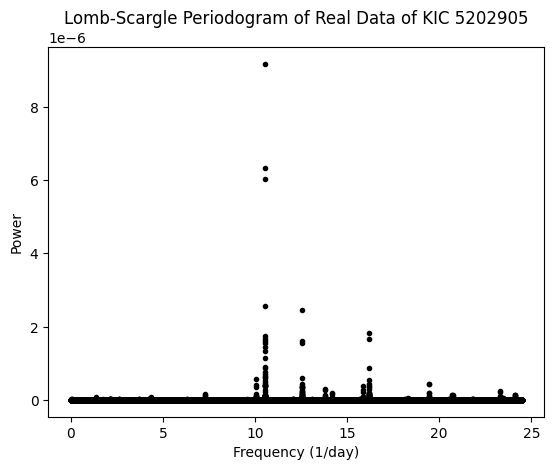

In [143]:
##Doing the same thing with real data

#time is in days


pg_real = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

real_power = pg_real.power.value
real_freq = pg_real.frequency.to(1/u.day).value 

plt.plot(real_freq, real_power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of Real Data of KIC 5202905")
plt.show() 

In [110]:
##Plotting the top 10 peaks in data
indx = nana.get_started(100,real_freq,real_power)

In [113]:
x_new,y_new, second_derivative = nana.refine_peaks(real_freq,real_power,indx)

In [152]:
(-second_derivative[0]/y_new[0])**(1/2)

np.float64(3563.0485693467685)

(10.533654497122999, 10.548615778782647)

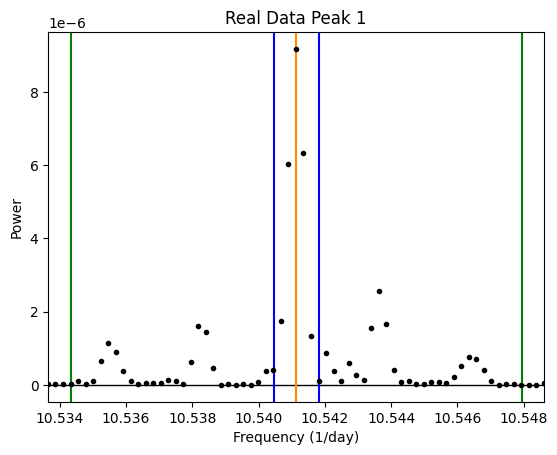

In [153]:
plt.title("Real Data Peak 1")
plt.axhline(y = 0., color='k', lw=1)
plt.axvline(x = x_new[0], color = 'darkorange')
plt.axvline(x = x_new[0]-delta_f, color = 'b')
plt.axvline(x = x_new[0]+delta_f, color = 'b')
plt.axvline(x = x_new[0]-10*delta_f, color = 'g')
plt.axvline(x = x_new[0]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq, real_power, 'k.')
plt.xlim(x_new[0]-11*delta_f, x_new[0]+11*delta_f)

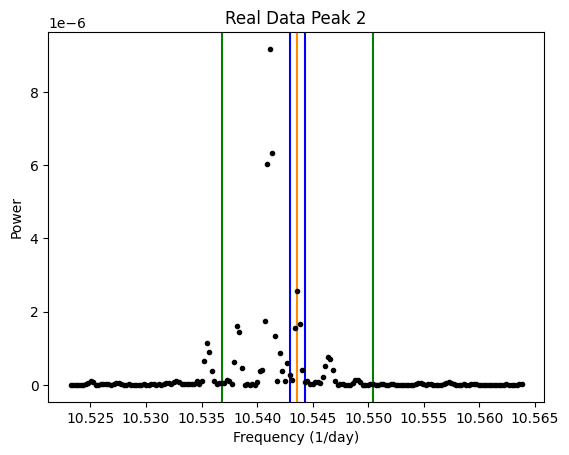

In [139]:
#Plot peak at 23088
plt.title("Real Data Peak 2")
#plt.axvline(x = real_freq[indx[1]], color = 'red')
plt.axvline(x = x_new[1], color = 'darkorange')
plt.axvline(x = real_freq[indx[1]]-delta_f, color = 'b')
plt.axvline(x = real_freq[indx[1]]+delta_f, color = 'b')
plt.axvline(x = real_freq[indx[1]]-10*delta_f, color = 'g')
plt.axvline(x = real_freq[indx[1]]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq[indx[1]-90:indx[1]+90], real_power[indx[1]-90:indx[1]+90], 'k.')

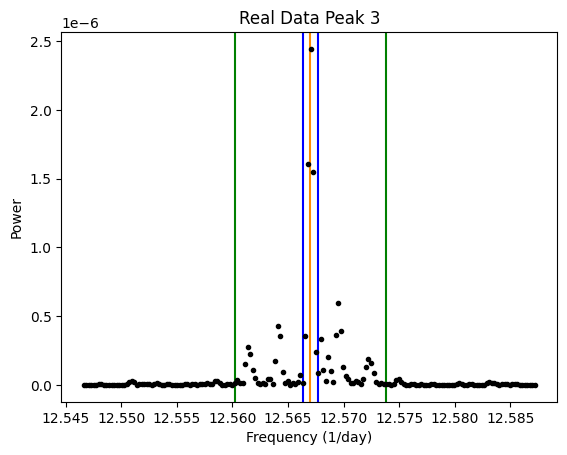

In [138]:
#Plot Thirds Peak
plt.title("Real Data Peak 3")
#plt.axvline(x = real_freq[indx[2]], color = 'red')
plt.axvline(x = x_new[2], color = 'darkorange')
plt.axvline(x = real_freq[indx[2]]-delta_f, color = 'b')
plt.axvline(x = real_freq[indx[2]]+delta_f, color = 'b')
plt.axvline(x = real_freq[indx[2]]-10*delta_f, color = 'g')
plt.axvline(x = real_freq[indx[2]]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq[indx[2]-90:indx[2]+90], real_power[indx[2]-90:indx[2]+90], 'k.')

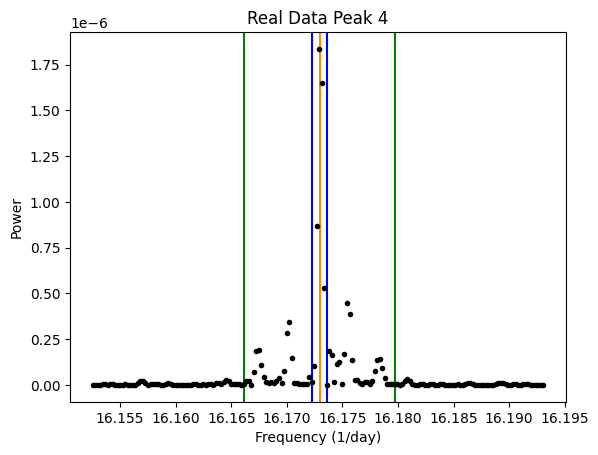

In [140]:
#Plot Fourth Peak
plt.title("Real Data Peak 4")
#plt.axvline(x = real_freq[indx[3]], color = 'red')
plt.axvline(x = x_new[3], color = 'darkorange')
plt.axvline(x = real_freq[indx[3]]-delta_f, color = 'b')
plt.axvline(x = real_freq[indx[3]]+delta_f, color = 'b')
plt.axvline(x = real_freq[indx[3]]-10*delta_f, color = 'g')
plt.axvline(x = real_freq[indx[3]]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq[indx[3]-90:indx[3]+90], real_power[indx[3]-90:indx[3]+90], 'k.')

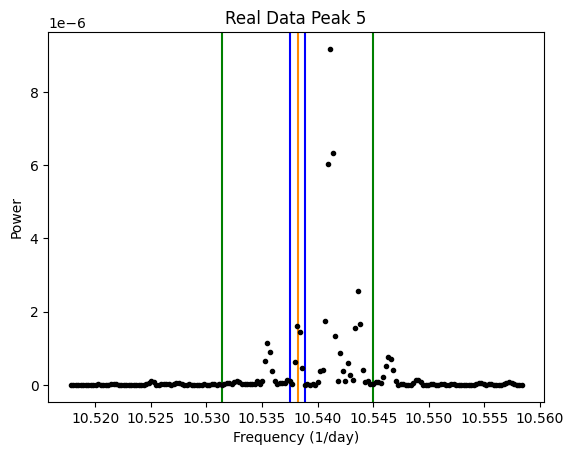

In [141]:
#Plot Fifth Peak
plt.title("Real Data Peak 5")
#plt.axvline(x = real_freq[indx[4]], color = 'red')
plt.axvline(x = x_new[4], color = 'darkorange')
plt.axvline(x = real_freq[indx[4]]-delta_f, color = 'b')
plt.axvline(x = real_freq[indx[4]]+delta_f, color = 'b')
plt.axvline(x = real_freq[indx[4]]-10*delta_f, color = 'g')
plt.axvline(x = real_freq[indx[4]]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq[indx[4]-90:indx[4]+90], real_power[indx[4]-90:indx[4]+90], 'k.')

In [130]:
#threshold function with original parameters, now that frequency spacing is accurate
def threshold10(indices, xs, ys):
    good_peaks = []
    for i in indices:
        leftside = ys[i-10:i]  
        rightside = ys[i+1:i+11]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        if ys[i] > 5*median:
            good_peaks.append(i)
    return np.array(good_peaks)

In [131]:
#No good peaks with real data
good_peaks_real = threshold10(indx, real_freq, real_power)
print(good_peaks_real)

[ 46500  46511  55437  71344  46487  46475  46523  55448  44342  71355
  85768  55424  69918  71332  60773  55412 102738  71320  55460  62557
  32045  44353  46535 106301  71368 106462  91376  91587  85778  46429
  44329  85755  69929  19131  60784  44317   5984  46571  69905  19242
   5988 103395  60760 102749  46559 102725  85743  44365  55472  69893
  80640  32056  46378  90609 106312  60748  53234  31989  16242  69227
  91598  71379 106473  55366  91364  71307]


In [132]:
#No good peaks with fake data
good_peaks_fake = threshold10(fake_ind, fake_freq, fake_power)
print(good_peaks_fake)

[8822 4410]


In [64]:
##More concise threshold function
def threshold_concise(indices, xs, ys):
    return np.array([i for i in indices if ys[i] > 5 * np.nanmedian(np.concatenate((ys[i-10:i], ys[i+1:i+11])))])